## The assignment ##

We want you use simulated events to try to separate a signal Higgs bosons from a background of DY Z bosons. We will give you events separated by decay channels:  where one $\tau$ has decayed to an electron and the other hadronically (et), where one $\tau$ has decayed to a $\mu$ and the other hadronically (mt), and where both have decayed hadronically (tt). We will give you samples for different processes i.e. Z bosons (DY), Higgs from ggH and Higgs from VBF. In each of these datasets we will give a series of event variables which will explained below.

Your assignment is to produce the sample that provides the best $\dfrac{S}{\sqrt{B+S}}$ where S is the number of signal events in your selection and B is the number of background events. When calculating this you must take into account the production rates of the Higgs compared to the Z and for the Higgs the ratio that are produced by ggH and VBF. You can do this by scaling the datasets that you have by:

DY : 8.4
ggH: 0.034
VBF: 0.011

## 1.Import necessary packages

The sklearn package provides a lot of machine lrarning classification tools. These tools are mainly used in this project.So in this part I import  necessary basic packages and classification tools.

In [5]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

In [6]:
import math
import pickle
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [7]:
from sklearn.svm import SVR
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.ensemble import GradientBoostingClassifier

In [8]:
rfc = RandomForestClassifier()
LR=LogisticRegression()
XGBC=XGBClassifier()
GBC=GradientBoostingClassifier()

## 2.Prepare the data for classification
If a variable shown below ends with {1,2}, this means that the variable exists for both the tau decay products 1 and 2. 1 refers to the leading transverse momentum hadronic tau in tt channel and the electron or muon in the et or mt channel. 2 refers to the subleading transverse momentum hadronic tau in tt channel and the hadronic tau in the et and mt channel.

- dR: Distance between the two tau decay products.
- dijetpt: Total transverse momentum of the two highest transverse momentum jets in the event.
- dphi: The angle phi between the two tau decay products.
- eta_{1,2}: The detector eta of the tau decay products.
- jdeta: The eta between the two highest transverse momentum jets in the event.
- jpt_1: The transverse momentum of the leading transverse momentum jet in the event.
- jpt_2: The transverse momentum of the subleading transverse momentum jet in the event.
- m_vis: The reconstructed mass of the visibile ditau decay products.
- met: The missing transverse energy in the event.
- met_dphi_{1,2}: The angle phi between the met and the tau decay product. 
- mjj: The reconstructed mass of the two highest transverse momentum jets in the event.
- mt_{1,2}: The transverse mass between the met and the tau decay product.
- mt_lep: The transverse mass between the two tau decay products.
- mt_tot: The sum in quadrature of mt_1, mt_2 and mt_lep.
- mva_dm_{1,2}: The predicted decay mode of the hadronic tau (1 only available for tt channel).
- n_deepbjets: The number of b tagged jets in the event.
- n_jets: The number of jets in the events.
- pt_{1,2}: The transverse momentum of the tau decay product.
- pt_tt: The reconstructed ditau + met transverse momentum.
- pt_vis: The reconstructed ditau transverse momentum.
- q_{1,2}: The charge of the tau decay product.
- svfit_mass: A likihood reconstruction of the ditau mass.

In [9]:
'''
This code reads in the data that you need into pandas dataframes.
It does this by channel (ch) and production process (proc).
'''
for ch in ["et","mt","tt"]:
    for proc in ["DY","ggH","VBF"]:
        url = "https://raw.githubusercontent.com/gputtley/ML-Assessment-3/master/{}_{}.pkl".format(ch,proc)
        exec(f"df_{ch}_{proc} = pd.read_pickle(url)") 

In [10]:
#Delete extra feature in "tt" channel
df_tt_DY=df_tt_DY.drop('mva_dm_1', axis='columns') 
df_tt_VBF=df_tt_VBF.drop('mva_dm_1', axis='columns') 
df_tt_ggH=df_tt_ggH.drop('mva_dm_1', axis='columns') 

Label the type of particles and label the channels they are generated from. 0 represents Z bosons and 1 represents Higgs bosons

In [11]:
df_et_DY["type"]=0
df_mt_DY["type"]=0
df_tt_DY["type"]=0
df_et_VBF["type"]=1
df_mt_VBF["type"]=1
df_tt_VBF["type"]=1
df_et_ggH["type"]=1
df_mt_ggH["type"]=1
df_tt_ggH["type"]=1

df_et_DY["index"]="et_DY"
df_mt_DY["index"]="mt_DY"
df_tt_DY["index"]="tt_DY"
df_et_VBF["index"]="et_VBF"
df_mt_VBF["index"]="mt_VBF"
df_tt_VBF["index"]="tt_VBF"
df_et_ggH["index"]="et_ggH"
df_mt_ggH["index"]="mt_ggH"
df_tt_ggH["index"]="tt_ggH"

Combine the data from all channels andproduction processes and generate a large dataset.

In [12]:
df_all = df_et_DY
df_all = df_all.append(df_mt_DY)
df_all = df_all.append(df_tt_DY)
df_all = df_all.append(df_et_VBF)
df_all = df_all.append(df_mt_VBF)
df_all = df_all.append(df_tt_VBF)
df_all = df_all.append(df_et_ggH)
df_all = df_all.append(df_mt_ggH)
df_all = df_all.append(df_tt_ggH)


In [13]:
#calculate rge correlation matrix
corr=df_all.corr()

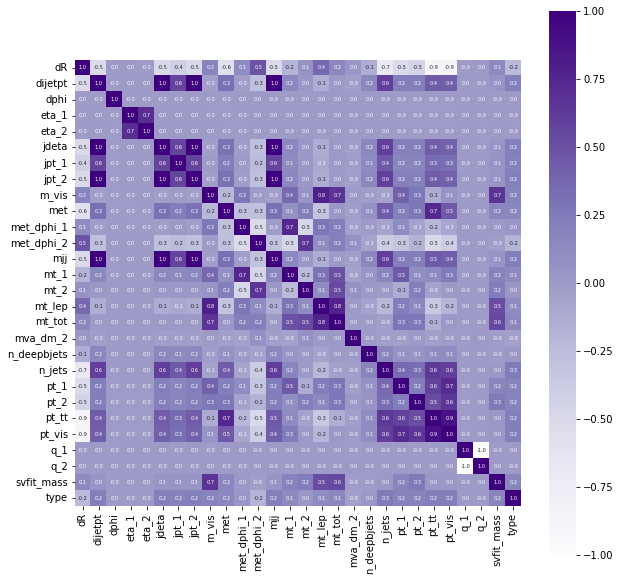

In [14]:
# set figure size
plt.figure(figsize=(10,10))

# correlation matrix
sns.heatmap(corr, cbar=True, square=True, fmt='.1f', annot=True,
            annot_kws={'size':5}, cmap='Purples')

# hide x-ticks
plt.tick_params(labelbottom = True)

We can see the type has **no strong correlation with all features** above so we selet all features here to train our model.

## 3.Classification on different thresholds and calculate $\dfrac{S}{\sqrt{B+S}}$ value.

### 3.1. Precision

Define the precition function. Precision is calculated by:

precision=$\dfrac{TP}{TP+FP}$

In [15]:
def precision_score(data_labels,data_class,data_labels_pred):
    #data_labels are real label of the data
    #dataclass are seperated by ch and proc
    #data_label_pred are predicted values
    TP_sum=0
    FP_sum=0
    for i in range(len(data_labels)):
        if((data_labels[i]==1)&(data_labels_pred[i]==1)):
            x=0
            if("DY" in data_class[i]):
                x=1
            elif("VBF" in data_class[i]):
                x=1
            elif("ggH" in data_class[i]):
                x=1
            TP_sum+=x
        if((data_labels[i]==0)&(data_labels_pred[i]==1)):
            x=0
            if("DY" in data_class[i]):
                x=1
            elif("VBF" in data_class[i]):
                x=1
            elif("ggH" in data_class[i]):
                x=1
            FP_sum+=x
    return TP_sum/(TP_sum+FP_sum)

def proba_to01(probas,x):
    result=[]
    for proba in probas:
        if(proba>=x):
            result.append(1)
        else:
            result.append(0)
    return result


df_2array=np.array(df_all)

samples=[list(data[1:-2]) for data in df_2array]
labels=[data[-2] for data in df_2array]
classes=[data[-1] for data in df_2array]
l_c=zip(labels,classes)
indexs=[]
for i,data in enumerate(l_c):
    indexs.append(i)
#The indexes correspond to the indexes of the data set, for example, the first index is 0 and the third index is 2.
#l_c_train_indexes indicates the array of indexes selected for the training set
#l_c_test_indexes indicates the array of indexes selected for the test set.
Xtrain, Xtest, l_c_train_indexs, l_c_test_indexs=train_test_split(samples,indexs,test_size=0.2)

ytrain=[labels[index] for index in l_c_train_indexs]
y_test=[labels[index] for index in l_c_test_indexs]
class_test=[classes[index] for index in l_c_test_indexs]

In [16]:
def my_score2(data_labels,data_class,data_labels_pred):
    #data is a 2 dimensional array
    #data_labels is real label
    #dataclass is seperated by "ch" and "proc"
    #data_label_pred are prediction results of the model
    TP_sum=0
    FP_sum=0
    for i in range(len(data_labels)):
        if((data_labels[i]==1)&(data_labels_pred[i]==1)):
            x=0
            if("DY" in data_class[i]):
                x=8.4
            elif("VBF" in data_class[i]):
                x=0.011
            elif("ggH" in data_class[i]):
                x=0.034
            TP_sum+=x
        if((data_labels[i]==0)&(data_labels_pred[i]==1)):
            x=0
            if("DY" in data_class[i]):
                x=8.4
            elif("VBF" in data_class[i]):
                x=0.011
            elif("ggH" in data_class[i]):
                x=0.034
            FP_sum+=x
    return TP_sum/math.sqrt(TP_sum+FP_sum)

def proba_to01(probas,x):
    result=[]
    for proba in probas:
        if(proba>=x):
            result.append(1)
        else:
            result.append(0)
    return result


df_2array=np.array(df_all)

samples=[list(data[1:-2]) for data in df_2array]
labels=[data[-2] for data in df_2array]
classes=[data[-1] for data in df_2array]
l_c=zip(labels,classes)
indexs=[]
for i,data in enumerate(l_c):
    indexs.append(i)

Xtrain, Xtest, l_c_train_indexs, l_c_test_indexs=train_test_split(samples,indexs,test_size=0.2)

ytrain=[labels[index] for index in l_c_train_indexs]
y_test=[labels[index] for index in l_c_test_indexs]
class_test=[classes[index] for index in l_c_test_indexs]






In [17]:
rfc = rfc.fit(Xtrain,ytrain)
#with open("rfc.pkl",'wb') as f:
#    pickle.dump(rfc,f)
y_pred_proba=rfc.predict_proba(Xtest)

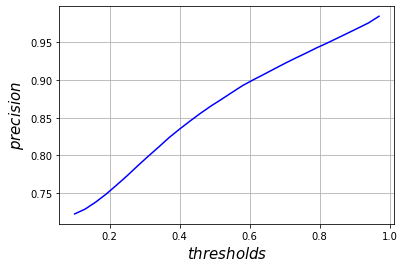

In [18]:
#A list for thresholds
thresholds=[i/100 for i in range(10,100,3)]


probas=[data[1] for data in y_pred_proba]
scores1=[]
accs=[]
precisions=[]
recalls=[]
for x in thresholds:
    preds=proba_to01(probas,x)
    scores1.append(precision_score(y_test,class_test,preds))

    #accs.append(accuracy_score(y_test,preds,average='binary'))
    #precisions.append(precision_score(y_test,preds,average='binary'))
    #recalls.append(recall_score(y_test,preds,average='binary'))
plt.plot(thresholds,scores1,"b")
plt.grid()
plt.xlabel("$thresholds$",fontsize=15)
plt.ylabel("$precision$",fontsize=15)
plt.show()


When threshold value increases, the precision value of the model increases, this is because that the  precision statistics the predicted value is 1 and the true value is 1. When the threshold sets higher, the  model can eliminate values that are not close to 1.

### 3.2. $\dfrac{S}{\sqrt{B+S}}$

Calculate $\dfrac{S}{\sqrt{B+S}}$ ( S is the number of signal events in your selection and B is the number of background events ). score=$\dfrac{TP}{\sqrt{TP+FP}}$.

score=$\dfrac{0.84*TPDY+0.034*TPggH+0.011*TPVBF}{\sqrt{0.84*TPDY+0.034*TPggH+0.011*TPVBF+0.84*FPDY+0.034*FPggH+0.011*FPVBF}}$

In [19]:
def TP(data_labels,data_class,data_labels_pred):
    #data_labels are real label of the data
    #dataclass are seperated by ch and proc
    #data_label_pred are predicted values
    TP_sum=0

    for i in range(len(data_labels)):
        if((data_labels[i]==1)&(data_labels_pred[i]==1)):
            x=0
            if("DY" in data_class[i]):
                x=8.4
            elif("VBF" in data_class[i]):
                x=0.011
            elif("ggH" in data_class[i]):
                x=0.034
            TP_sum+=x


    return TP_sum
def FP(data_labels,data_class,data_labels_pred):

    FP_sum=0
    for i in range(len(data_labels)):
        if((data_labels[i]==0)&(data_labels_pred[i]==1)):
            x=0
            if("DY" in data_class[i]):
                x=8.4
            elif("VBF" in data_class[i]):
                x=0.011
            elif("ggH" in data_class[i]):
                x=0.034
            FP_sum+=x
    return FP_sum

In [20]:
thresholds=[i/100 for i in range(1,100,1)]


probas=[data[1] for data in y_pred_proba]
scores1=[]
accs=[]
precisions=[]
recalls=[]
BG1=[]
S1=[]
for x in thresholds:
    preds=proba_to01(probas,x)
    scores1.append(my_score2(y_test,class_test,preds))
    S1.append(TP(y_test,class_test,preds)+FP(y_test,class_test,preds))
    BG1.append(FP(y_test,class_test,preds))
max_indx=np.argmax(scores1)#max value index

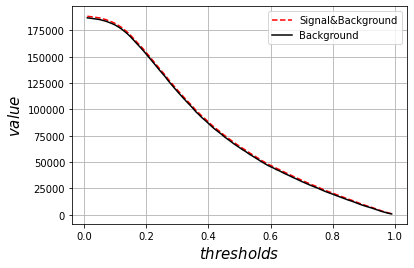

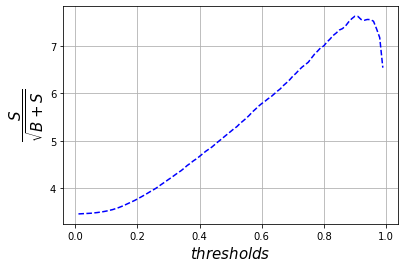

In [22]:
plt.plot(thresholds,S1,"r--",label='Signal&Background')

plt.plot(thresholds,BG1,"k",label='Background')
plt.grid()
plt.legend()
plt.xlabel("$thresholds$",fontsize=15)
plt.ylabel("$value$",fontsize=15)
plt.show()

plt.plot(thresholds,scores1,"b--")

#plt.text(0.75,7.5,'max',family='monospace',fontsize=16,color='r')
plt.grid()
plt.xlabel("$thresholds$",fontsize=15)
plt.ylabel("$\dfrac{S}{\sqrt{B+S}}$",fontsize=15)
plt.show()


The above result shows when threshold value increses, the defined score increases when the value reaches to 0.9 and the score decreases when the threshold is higher than 0.9. The defined score represents the ability of identifying the signal and background of this model.

## 4.Multiple Methods

### Method: GradientBoostingClassifier

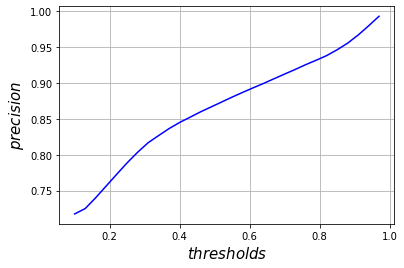

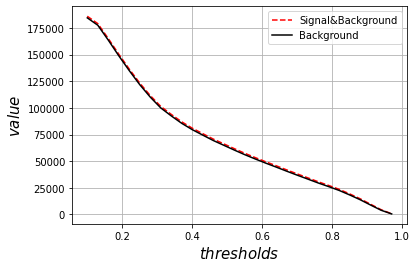

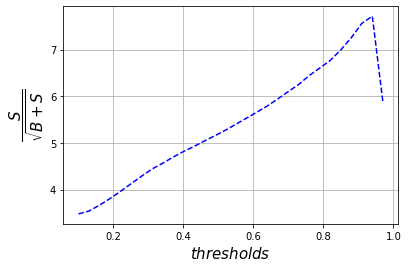

In [27]:
GBC=GBC.fit(Xtrain_shape,ytrain_shape)
y_pred_proba_GBC=GBC.predict_proba(Xtest)
thresholds=[i/100 for i in range(10,100,3)]
probas=[data[1] for data in y_pred_proba_GBC]
scores6=[]
accs=[]
precisions=[]
recalls=[]
for x in thresholds:
    preds=proba_to01(probas,x)
    scores6.append(precision_score(y_test,class_test,preds))
plt.plot(thresholds,scores6,"b")
plt.grid()
plt.xlabel("$thresholds$",fontsize=15)
plt.ylabel("$precision$",fontsize=15)
plt.show()
scores7=[]
BG7=[]
S7=[]
for x in thresholds:
    preds=proba_to01(probas,x)
    scores7.append(my_score2(y_test,class_test,preds))
    S7.append(TP(y_test,class_test,preds)+FP(y_test,class_test,preds))
    BG7.append(FP(y_test,class_test,preds))
max_indx=np.argmax(scores7)#max value index

plt.plot(thresholds,S7,"r--",label='Signal&Background')

plt.plot(thresholds,BG7,"k",label='Background')
plt.grid()
plt.legend()
plt.xlabel("$thresholds$",fontsize=15)
plt.ylabel("$value$",fontsize=15)
plt.show()

plt.plot(thresholds,scores7,"b--")

#plt.text(0.75,7.5,'max',family='monospace',fontsize=16,color='r')
plt.grid()
plt.xlabel("$thresholds$",fontsize=15)
plt.ylabel("$\dfrac{S}{\sqrt{B+S}}$",fontsize=15)
plt.show()


When threshold value increases, the precision value of the model increases, this is because that the  precision statistics the predicted value is 1 and the true value is 1. When the threshold sets higher, the  model can eliminate values that are not close to 1.

The above result shows when threshold value increses, the defined score increases when the value reaches to 0.94 and the score decreases when the threshold is higher than 0.94. The defined score represents the ability of identifying the signal and background of this model.

### Method: XGBC

In [24]:
Xtrain_shape = np.array(Xtrain)
ytrain_shape = np.array(ytrain)

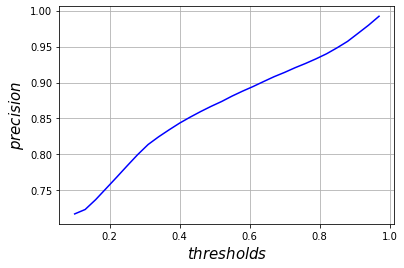

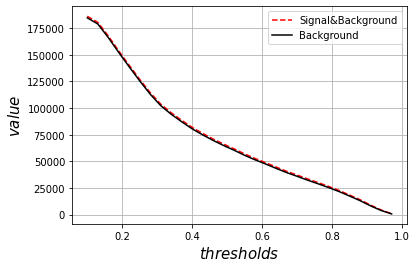

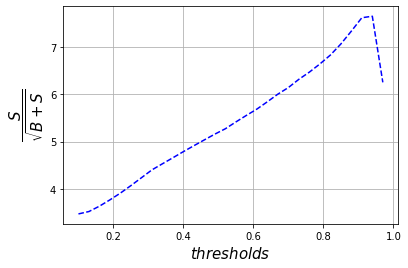

In [26]:
XGBC=XGBC.fit(Xtrain_shape,ytrain_shape)
y_pred_proba_XGBC=XGBC.predict_proba(Xtest)
thresholds=[i/100 for i in range(10,100,3)]
probas=[data[1] for data in y_pred_proba_XGBC]
scores4=[]
accs=[]
precisions=[]
recalls=[]
for x in thresholds:
    preds=proba_to01(probas,x)
    scores4.append(precision_score(y_test,class_test,preds))
plt.plot(thresholds,scores4,"b")
plt.grid()
plt.xlabel("$thresholds$",fontsize=15)
plt.ylabel("$precision$",fontsize=15)
plt.show()
scores5=[]
BG5=[]
S5=[]
for x in thresholds:
    preds=proba_to01(probas,x)
    scores5.append(my_score2(y_test,class_test,preds))
    S5.append(TP(y_test,class_test,preds)+FP(y_test,class_test,preds))
    BG5.append(FP(y_test,class_test,preds))
max_indx=np.argmax(scores5)#max value index

plt.plot(thresholds,S5,"r--",label='Signal&Background')

plt.plot(thresholds,BG5,"k",label='Background')
plt.grid()
plt.legend()
plt.xlabel("$thresholds$",fontsize=15)
plt.ylabel("$value$",fontsize=15)
plt.show()

plt.plot(thresholds,scores5,"b--")

#plt.text(0.75,7.5,'max',family='monospace',fontsize=16,color='r')
plt.grid()
plt.xlabel("$thresholds$",fontsize=15)
plt.ylabel("$\dfrac{S}{\sqrt{B+S}}$",fontsize=15)
plt.show()


When threshold value increases, the precision value of the model increases, this is because that the  precision statistics the predicted value is 1 and the true value is 1. When the threshold sets higher, the  model can eliminate values that are not close to 1.

The above result shows when threshold value increses, the defined score increases when the value reaches to 0.92 and the score decreases when the threshold is higher than 0.92. The defined score represents the ability of identifying the signal and background of this model.

### Method: Logistic Regression

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


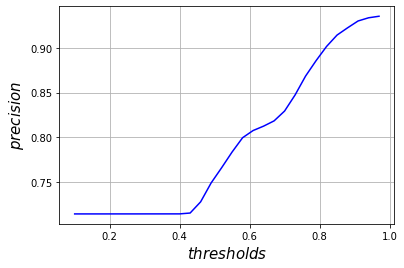

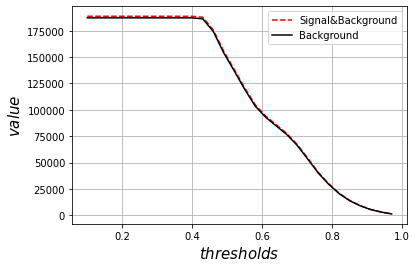

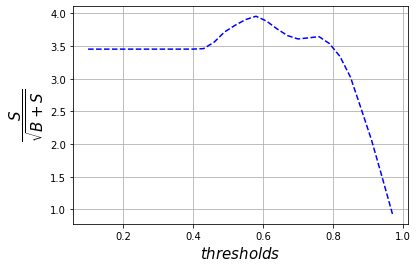

In [23]:
LR=LR.fit(Xtrain,ytrain)
y_pred_proba_LR=LR.predict_proba(Xtest)
thresholds=[i/100 for i in range(10,100,3)]
probas=[data[1] for data in y_pred_proba_LR]
scores2=[]
accs=[]
precisions=[]
recalls=[]
for x in thresholds:
    preds=proba_to01(probas,x)
    scores2.append(precision_score(y_test,class_test,preds))
plt.plot(thresholds,scores2,"b")
plt.grid()
plt.xlabel("$thresholds$",fontsize=15)
plt.ylabel("$precision$",fontsize=15)
plt.show()
scores3=[]
BG2=[]
S2=[]
for x in thresholds:
    preds=proba_to01(probas,x)
    scores3.append(my_score2(y_test,class_test,preds))
    S2.append(TP(y_test,class_test,preds)+FP(y_test,class_test,preds))
    BG2.append(FP(y_test,class_test,preds))
max_indx=np.argmax(scores3)#max value index

plt.plot(thresholds,S2,"r--",label='Signal&Background')

plt.plot(thresholds,BG2,"k",label='Background')
plt.grid()
plt.legend()
plt.xlabel("$thresholds$",fontsize=15)
plt.ylabel("$value$",fontsize=15)
plt.show()

plt.plot(thresholds,scores3,"b--")

#plt.text(0.75,7.5,'max',family='monospace',fontsize=16,color='r')
plt.grid()
plt.xlabel("$thresholds$",fontsize=15)
plt.ylabel("$\dfrac{S}{\sqrt{B+S}}$",fontsize=15)
plt.show()


When threshold value increases, the precision value of the model increases, this is because that the  precision statistics the predicted value is 1 and the true value is 1. When the threshold sets higher, the  model can eliminate values that are not close to 1.

The above result shows when threshold value increses, the defined score increases when the value reaches to 0.58 and the score decreases when the threshold is higher than 0.58. The defined score represents the ability of identifying the signal and background of this model.

## 5.Summary
In this task I utilized rendom several classifiers and Logistici Regression method to seperate the signal from higgs bosons and Z bosons. I calculated the TT, FT value and obtained $\dfrac{S}{\sqrt{B+S}}$ value on different thresholds. The calculation result show that when the threshold was set as approximately 0.92, 0.93  or 0.95, the forest classifier models can obtain the max value of $\dfrac{S}{\sqrt{B+S}}$ on the testset. The Logistic Regression method generates a different maximum value when threshold is approximately  0.58.